# GHCN Temperature anomaly dataset analysis -- in Python

GHCN is a large matrix of global historical temperature data, from 1880 to 2016
(it is freely available; we downloaded it from <a href="ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/v3/grid/">ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/v3/grid/</a>).
A not-very-easy-to-read technical paper describing the dataset is at
<a href="http://onlinelibrary.wiley.com/doi/10.1029/2011JD016187/pdf">http://onlinelibrary.wiley.com/doi/10.1029/2011JD016187/pdf</a>).

The data stores values for the whole globe using a grid, which has a resolution of $5^{\circ} \times 5^{\circ}$.
In other words, the grid has 36 rows (for latitude) and 72 columns (for longitude).
Although the earth is spherical and a $36 \times 72$ rectangular grid introduces distortion,
for this problem we will follow this approach.

The GHCN dataset covers $2016 - 1880 + 1 = 137$ years, with 12 months per year.
So the data set contains $137 \times 12$ grids.
The <tt>ghcn.csv</tt> file storing the data is basically a $(36 \times 12 \times 137) \times 72$ matrix of temperature values.
It is stored as a 2D matrix of size $(36 \times 12 \times 137) \times 72$, along with two initial columns giving the year and month.

The script <tt>ghcn_script.py</tt> reads in the data file and reshapes it for you
into a 4D matrix of size $36 \times 12 \times 137 \times 72$.

Actually, the GHCN data gives "anomaly" values instead of temperature values.
That is, it gives values of how far the temperature was from normal in that grid square in that month.
Positive values are above normal; all values are in Celsius.
(Why does it give anomaly values only?  The paper explains why computing actual temperatures is much harder.)

The point of this dataset in the assignment is that it permits us to use "slices" to do a lot of work.
For example, it turns out the coordinates of most of the continental U.S. are the rectangle
with rows 9:12 and columns 14:20  [in Python these are 8:11 and 13:19].

-- D.S. Parker, Fall 2016.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
GHCN = pd.read_csv('ghcn.csv', header=None).fillna(0).as_matrix()

#   The data was artificially shifted to [0, 4500]
#     its range should be [-2500, +2000]/100 = [-25,+20], in degrees Centigrade.
#     Since our focus here is on warming, we ignore temperatures below -5.
#   We omit the year and month in columns 1:2 before scaling:

GHCN_in_centigrade  = (GHCN[:,2:74] - 2500.0) / 100.0                        # omit the first two columns
GHCN_in_centigrade.shape

(59184, 72)

In [4]:
temperature_anomaly = np.reshape( GHCN_in_centigrade, (36, 12, 137, 72), order="F" )
# convert to a 4D matrix, so we can use slices; use Fortran conventions, like Matlab

temperature_anomaly.shape

(36, 12, 137, 72)

In [5]:
number_of_all_GHCN_values = np.prod( temperature_anomaly.shape )
number_of_all_GHCN_values

4261248

In [6]:
missing_values     = (temperature_anomaly == -25)
non_missing_values = (temperature_anomaly != -25)

number_of_missing_values = missing_values.sum()
number_of_missing_values

3620065

In [7]:
maximum_anomaly_value = temperature_anomaly.max()
maximum_anomaly_value

19.940000000000001

In [8]:
minimum_anomaly_value = temperature_anomaly[non_missing_values].min()
minimum_anomaly_value

-24.260000000000002

In [9]:
year_month_anomaly = lambda Y,M: np.reshape( temperature_anomaly[:, M-1][:, :, Y-1880], (36,72), order="F")
year_month_missing = lambda Y,M: np.reshape(      missing_values[:, M-1][:, :, Y-1880], (36,72), order="F")

In [10]:
US_latitude  = np.arange(8,12)
US_longitude = np.arange(14,20)
my_years = np.arange(1916,2016)
my_year_indices = np.arange(1916-1880,2016-1880)

In [11]:
temperature_anomaly[US_latitude][:,6,136,US_longitude] # anomaly in the for July 2016

array([[-0.11,  0.04, -0.11,  0.43,  0.8 ,  1.32],
       [ 0.7 ,  0.2 , -0.16, -0.14,  0.33,  1.18],
       [ 0.75,  1.52,  0.5 ,  0.56,  0.6 ,  1.19],
       [ 2.08,  2.64,  1.58,  0.77,  1.13,  1.63]])

In [12]:
my_slice = temperature_anomaly[ US_latitude ][ :, :, my_year_indices][ :, :, :, US_longitude ]
my_slice.shape

(4, 12, 100, 6)

In [13]:
total_number_of_grid_squares = len(US_latitude) * len(US_longitude) * 12
N = total_number_of_grid_squares
N

288

In [14]:
len(my_years)

100

In [15]:
average_US_anomaly_by_year = np.reshape( my_slice.sum(axis=3).sum(axis=1).sum(axis=0), (len(my_years), 1) ) / N
# order="F" is not needed for this reshape since the result is a vector

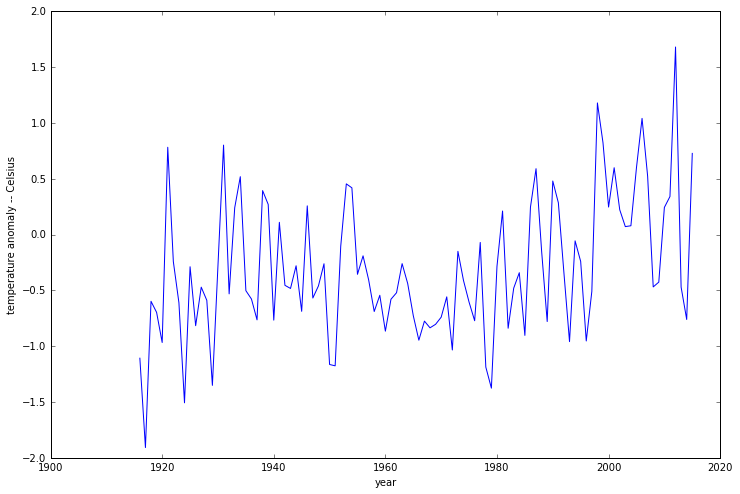

In [16]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

plt.plot( my_years, average_US_anomaly_by_year )
plt.xlabel('year')
plt.ylabel('temperature anomaly -- Celsius')
plt.show()
